#### Bibliotecas

In [34]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.features import shapes
from shapely.geometry import shape
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm


#### Parâmetros

In [21]:
subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
raster_file = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/9_Dissertação/Resultados/Pacote_01/Raw/pct1_h_max_2768400.tif'
threshold = 0.3

#### Execução

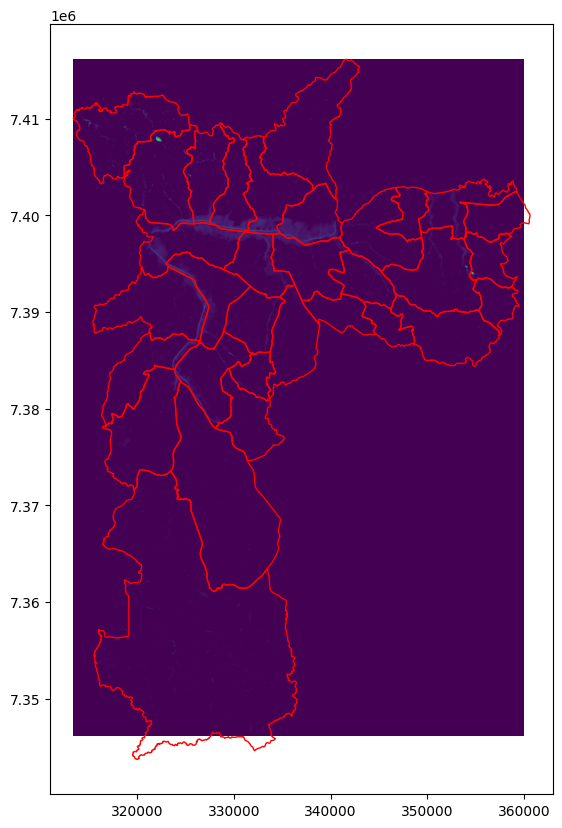

In [6]:
# Carregar o shapefile
gdf = gpd.read_file(subprefeituras_shp)

# Abrir o arquivo raster
raster_path = raster_file
raster = rasterio.open(raster_path)

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o raster
show(raster, ax=ax)

# Plotar o shapefile por cima
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

# Exibir o mapa
plt.show()

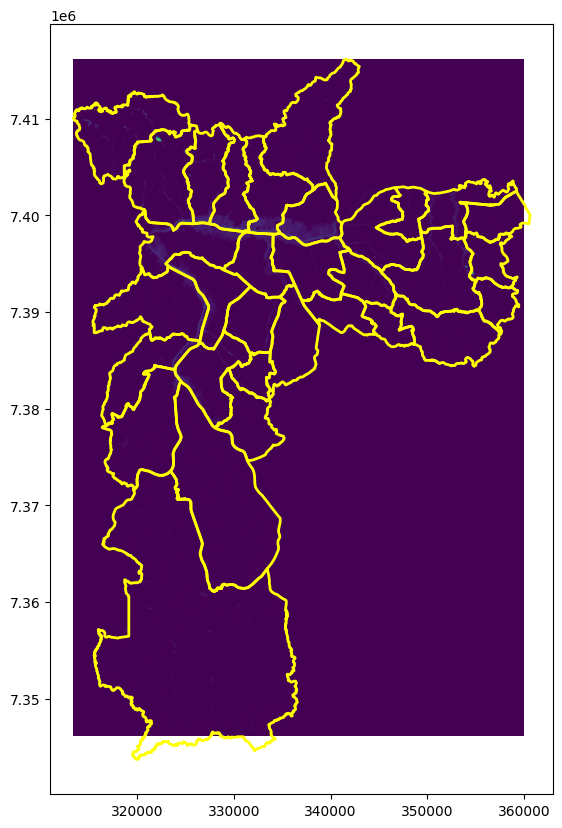

In [22]:
# Carregar o shapefile
gdf = gpd.read_file(subprefeituras_shp)

# Abrir o arquivo raster
raster_path = raster_file
with rasterio.open(raster_path) as raster:
    raster_data = raster.read(1).astype(float)  # Garantir que seja um array NumPy
    transform = raster.transform
    raster_crs = raster.crs  # Salvar o CRS antes de fechar
    
    # Criar máscara para valores > 7 cm
    mask = raster_data > threshold
    
    # Converter a máscara para vetores (polígonos)
    shapes_gen = shapes(raster_data, mask=mask, transform=transform)
    polygons = [shape(geom) for geom, value in shapes_gen if value]
    
# Criar GeoDataFrame com os polígonos detectados
high_values_gdf = gpd.GeoDataFrame(geometry=polygons, crs=raster.crs)
    
# Interseccionar com as subprefeituras
highlighted_subs = gdf[gdf.intersects(high_values_gdf.union_all())]

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o raster
tmp_raster = rasterio.open(raster_path)  # Reabrir o raster
show(tmp_raster.read(1), transform=tmp_raster.transform, ax=ax)
tmp_raster.close()

# Plotar o shapefile por cima
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

# Destacar as subprefeituras afetadas
highlighted_subs.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=2)

# Exibir o mapa
plt.show()

In [38]:
# Contar pixels por subprefeitura e calcular percentual acima do threshold
results = []
with rasterio.open(raster_path) as raster:
    for _, subpref in gdf.iterrows():
        mask = rasterio.features.geometry_mask([subpref.geometry], transform=raster.transform, invert=True, out_shape=raster.shape)
        total_pixels = np.sum(mask)
        exceed_pixels = np.sum((raster_data > threshold) & mask)
        exceed_percentage = round((exceed_pixels / total_pixels) * 100, 2) if total_pixels > 0 else 0
        results.append([subpref["sp_nome"], total_pixels, exceed_pixels, exceed_percentage])

# Criar DataFrame de resultados
results_df = pd.DataFrame(results, columns=["Subprefeitura", "Total Pixels", "Exceed Pixels", "Exceeding Threshold"])

# Ordenar pelo percentual de pixels que excedem o threshold
results_df = results_df.sort_values(by="Exceeding Threshold", ascending=False)
results_df

,Subprefeitura,Total Pixels,Exceed Pixels,Exceeding Threshold
8,VILA MARIA-VILA GUILHERME,31632,14530,45.93
2,LAPA,47796,16895,35.35
4,SE,31366,8845,28.20
6,PINHEIROS,37622,10510,27.94
5,SANTANA-TUCURUVI,42071,8440,20.06
14,SAO MIGUEL,30739,6158,20.03
9,MOOCA,42381,8222,19.40
1,CASA VERDE-CACHOEIRINHA,32033,6205,19.37
25,SANTO AMARO,44374,8319,18.75
16,ARICANDUVA-FORMOSA-CARRAO,26273,3880,14.77


In [43]:
# Remover colunas duplicadas antes do merge
gdf = gdf.drop(columns=["Total Pixels", "Exceed Pixels", "Exceeding Threshold"], errors="ignore")

# Mesclar os resultados ao GeoDataFrame
gdf = gdf.merge(results_df, left_on="sp_nome", right_on="Subprefeitura", how="left")

# Criar colormap
norm = mcolors.Normalize(vmin=gdf["Exceeding Threshold"].min(), vmax=gdf["Exceeding Threshold"].max())
cmap = cm.get_cmap("Reds")

# Criar mapa de calor
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column="Exceeding Threshold", cmap=cmap, edgecolor='black', linewidth=1, legend=True, norm=norm)
plt.title("Mapa de Calor das Subprefeituras - Percentual Acima do Threshold")
plt.show()


MergeError: Passing 'suffixes' which cause duplicate columns {'Subprefeitura_x'} is not allowed.